### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from allensdk.core.nwb_data_set import NwbDataSet
import seaborn as sns
import pg8000
import os

sns.set_style('white')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Data Paths

In [2]:
def nwb_linux(Linuxpath):
    #converts to linux path in LIMS to Windows path and adds the nwb
    
    SplitLinux = Linuxpath.split('/')
    try:
        return (r"\\" + os.path.join(SplitLinux[1], SplitLinux[2],SplitLinux[3],SplitLinux[4], SplitLinux[5],SplitLinux[6],SplitLinux[7],
                                     SplitLinux[7].split('_')[-1] + '.nwb'))
    except (WindowsError, AttributeError, IndexError):
        try:
            return (r"\\" + os.path.join('titan','cns', SplitLinux[2], SplitLinux[4],
                                         SplitLinux[5],SplitLinux[5].split('_')[-1] + '.nwb'))
        except (WindowsError, AttributeError, IndexError):
            return None
            print 'Could not find cell'

### View the Sweeps

Cell: H17.26.005.11.03.04


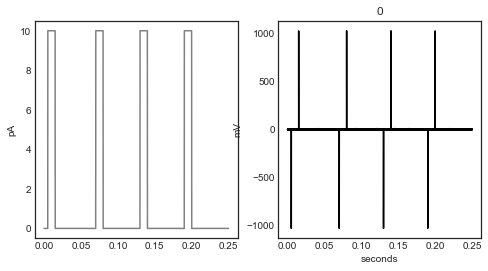

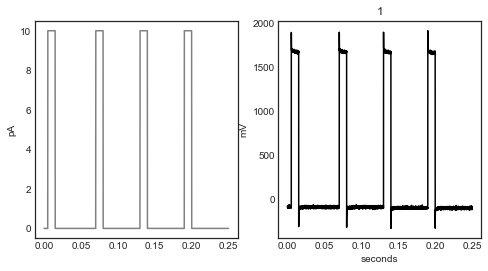

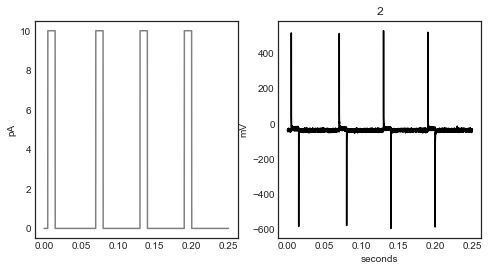

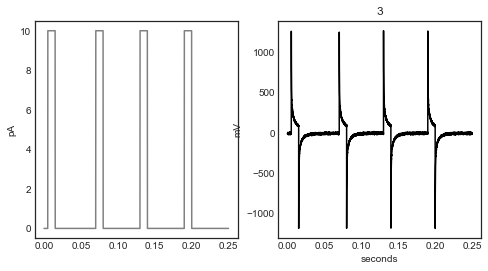

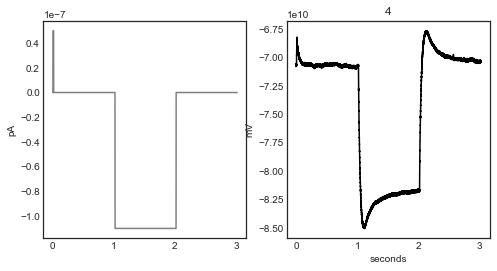

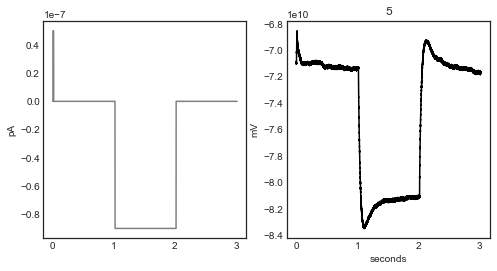

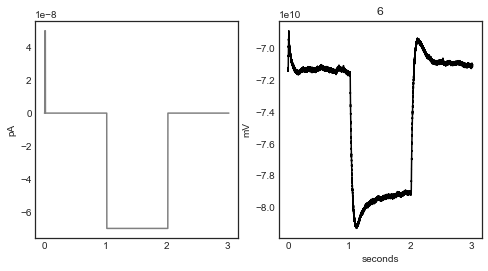

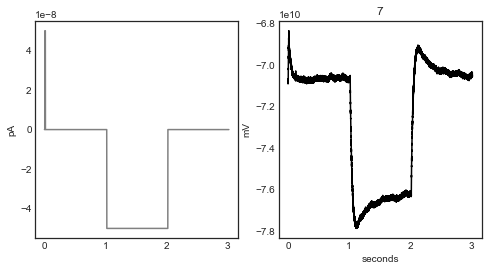

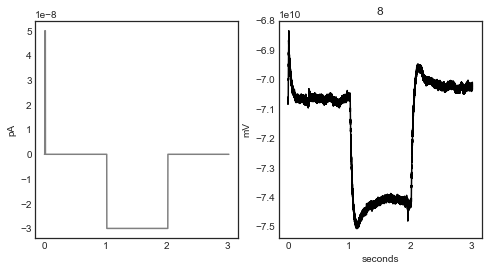

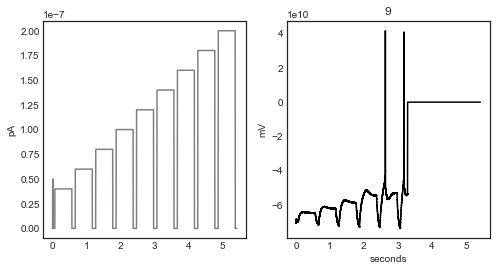

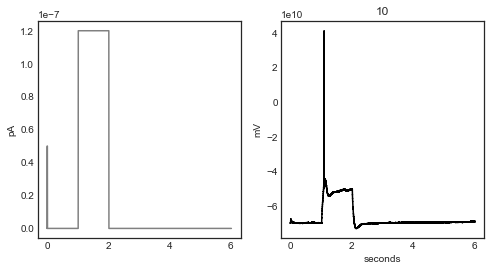

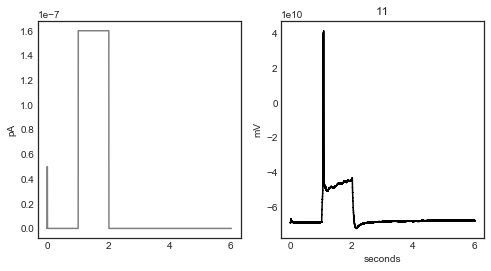

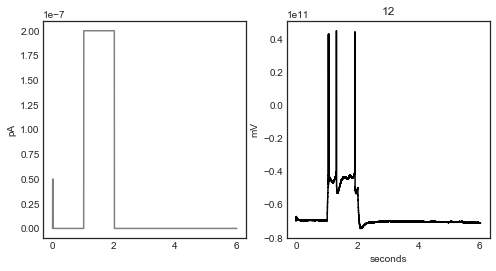

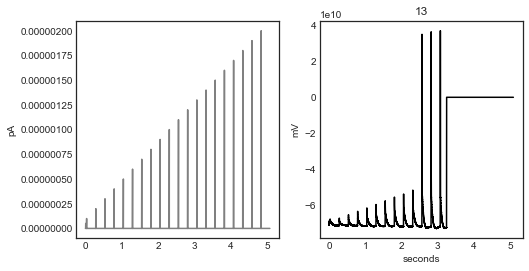

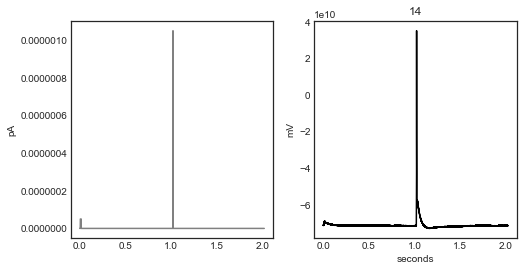

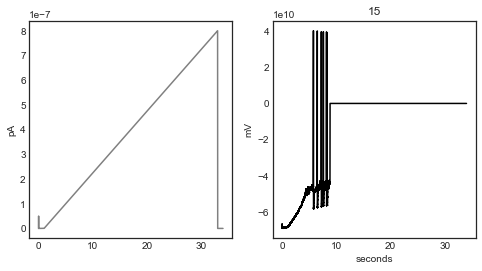

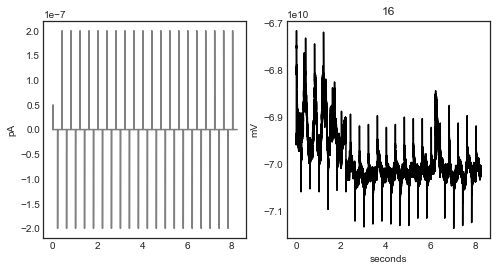

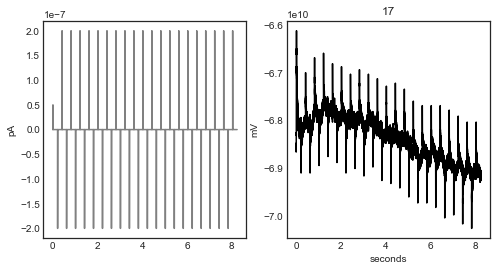

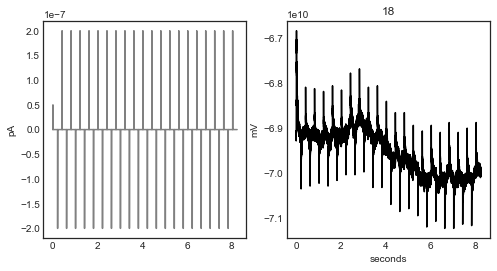

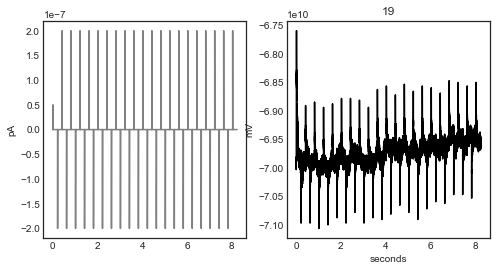

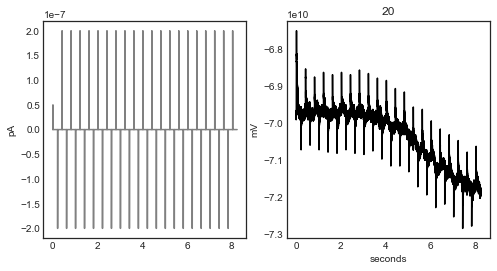

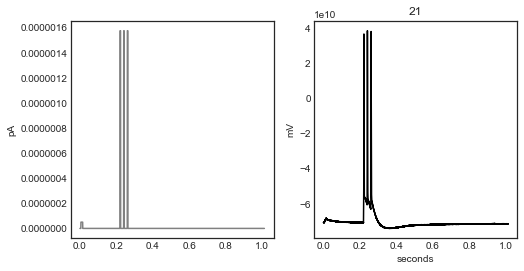

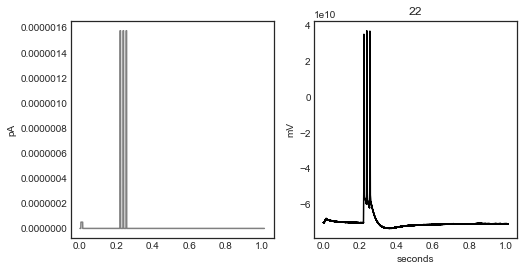

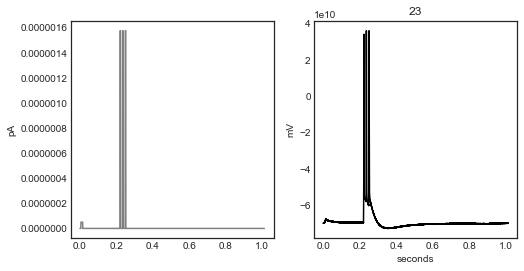

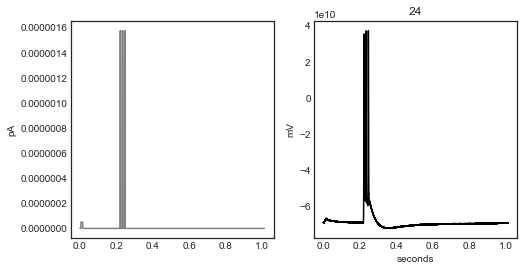

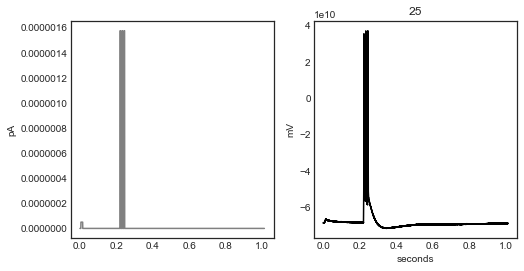

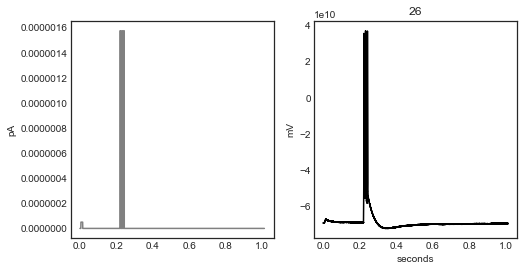

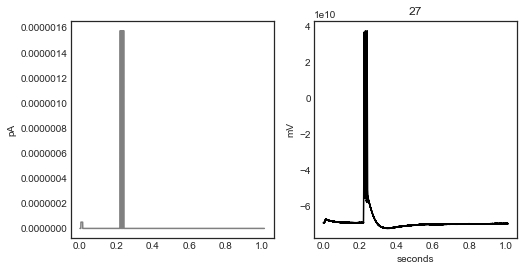

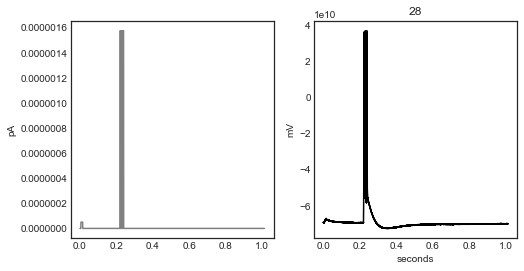

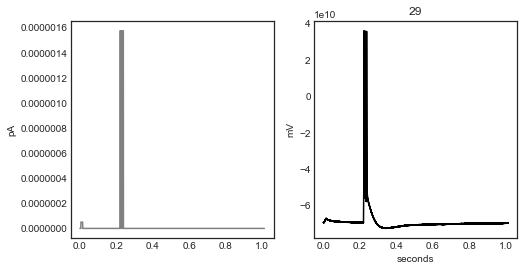

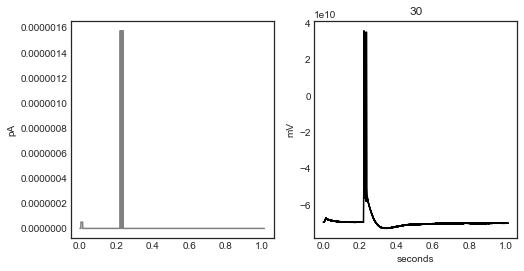

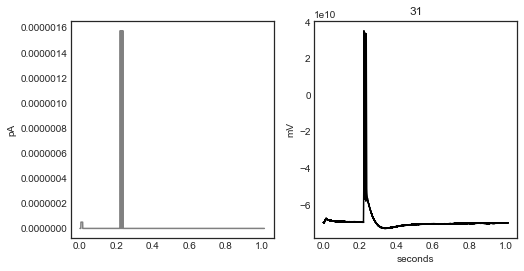

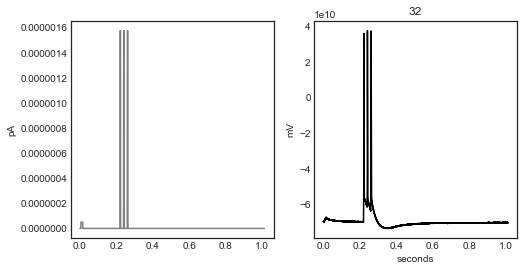

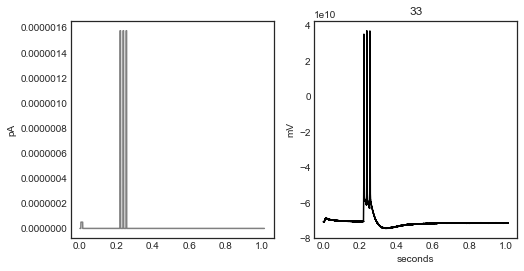

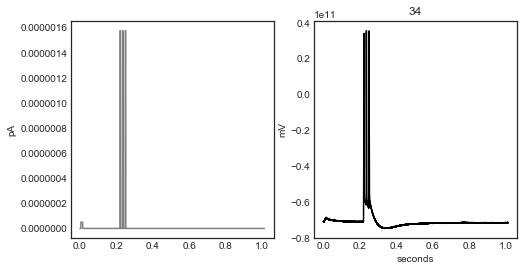

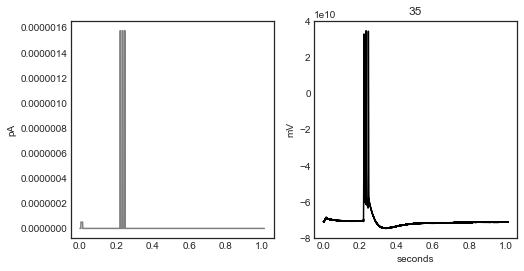

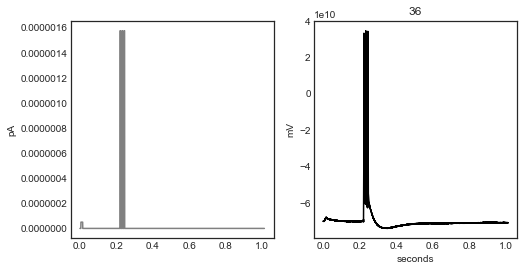

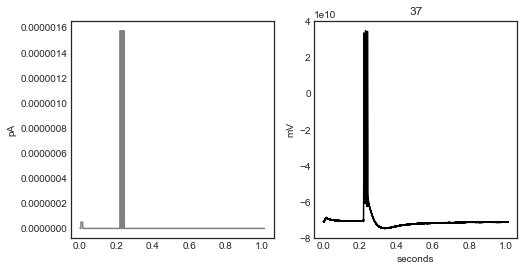

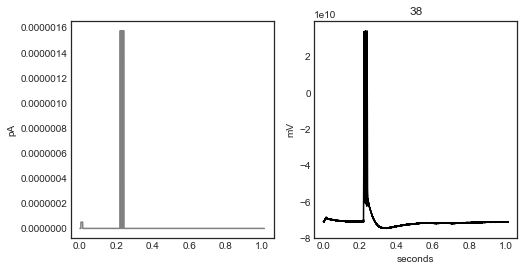

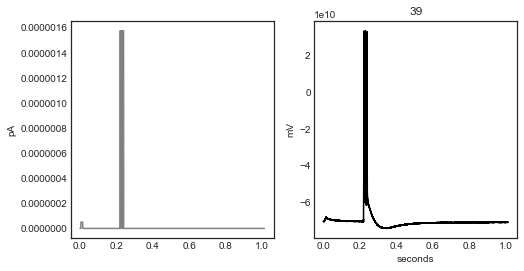

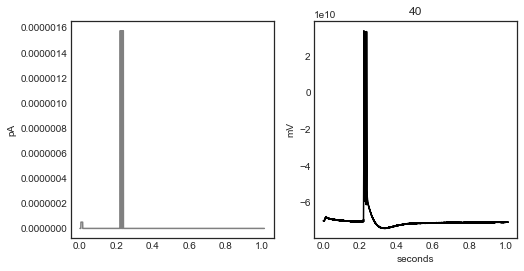

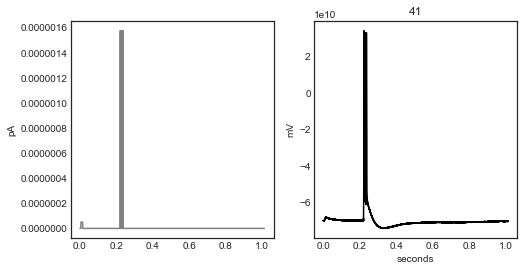

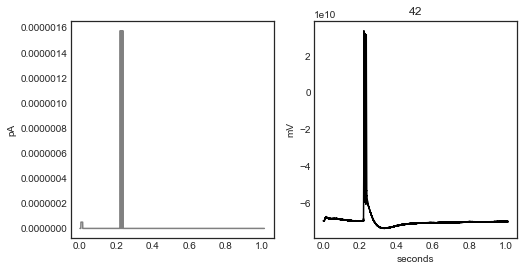

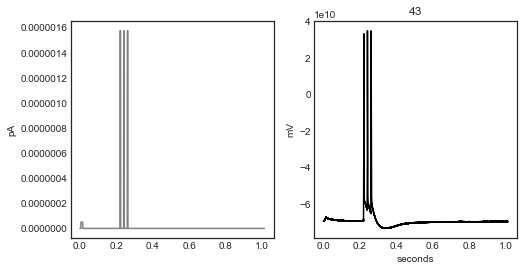

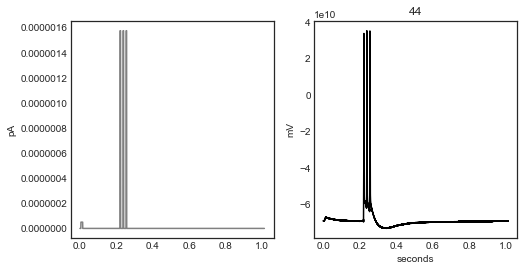

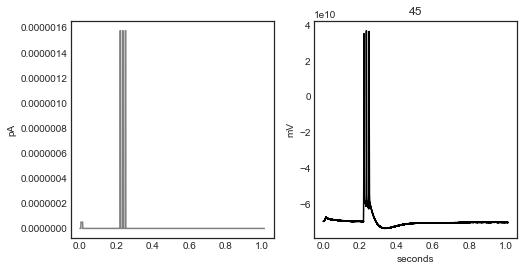

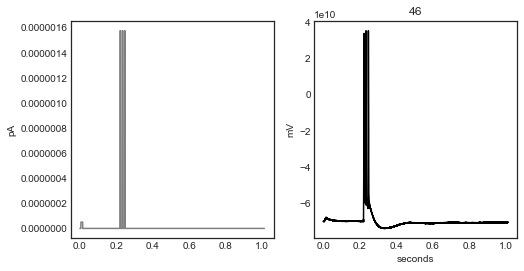

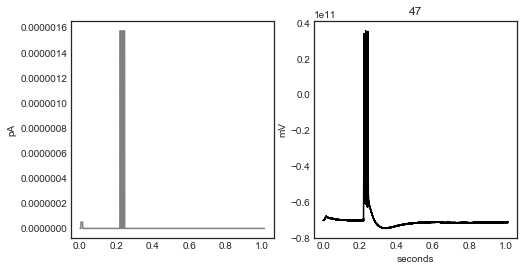

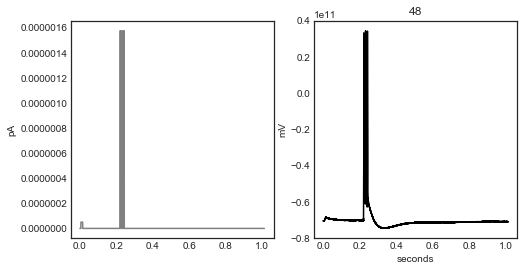

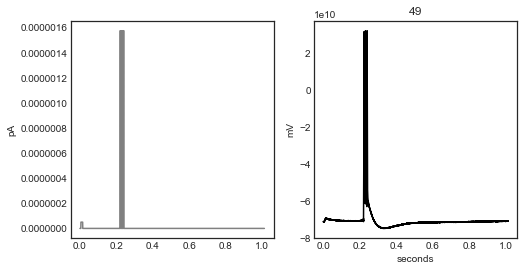

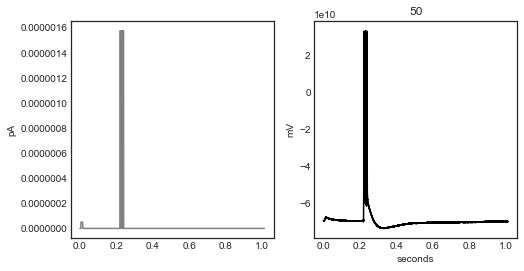

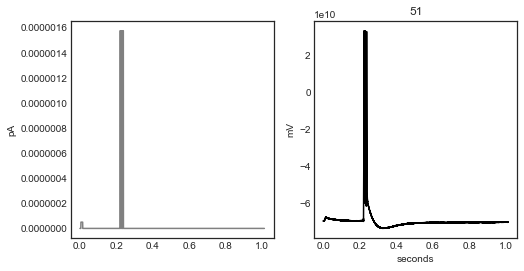

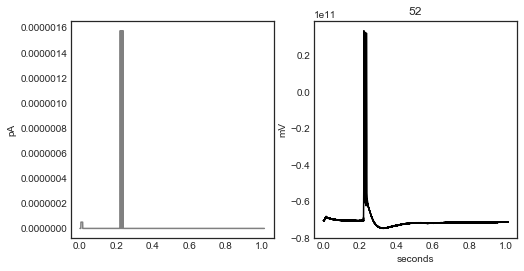

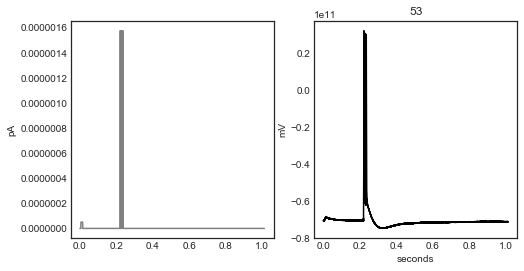

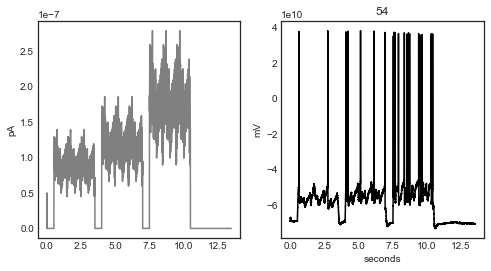

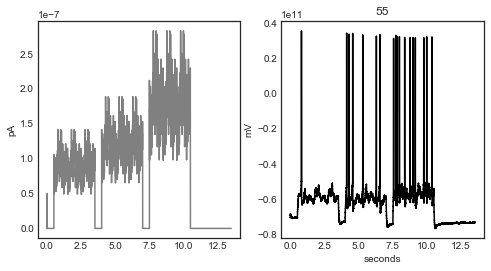

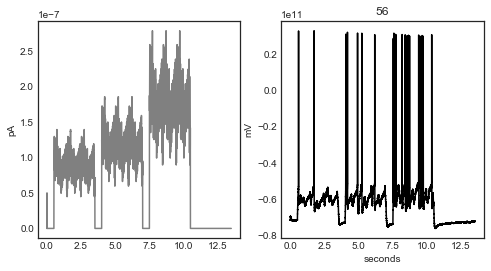

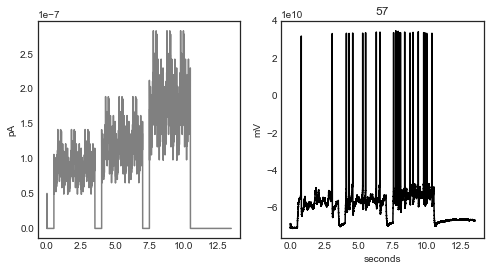

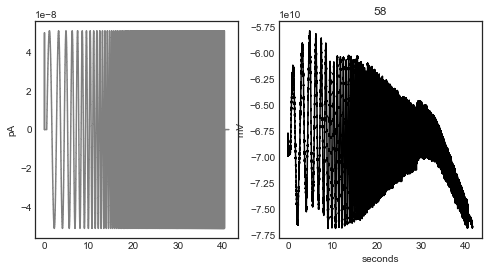

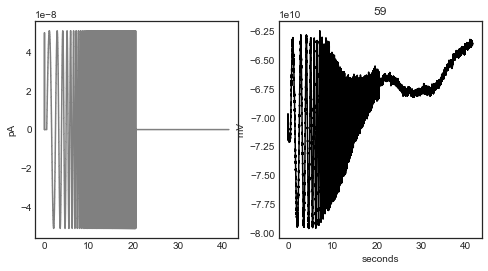

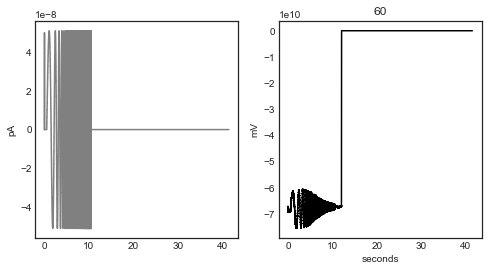

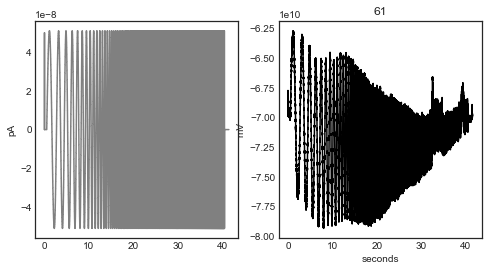

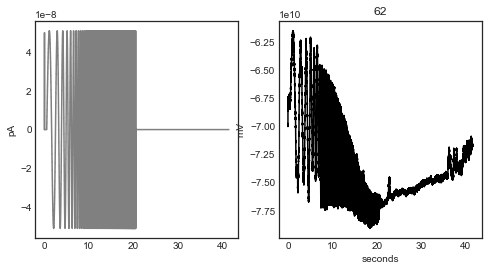

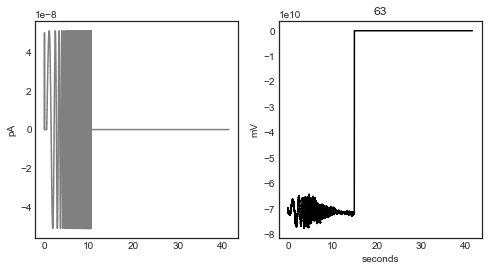

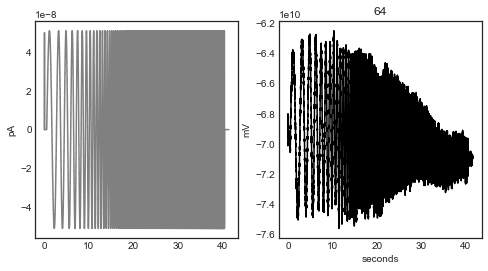

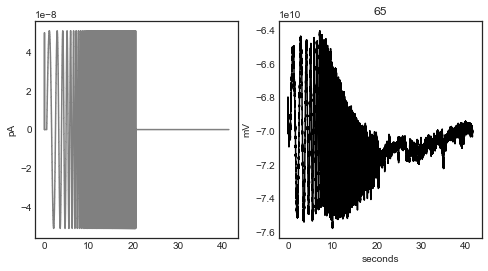

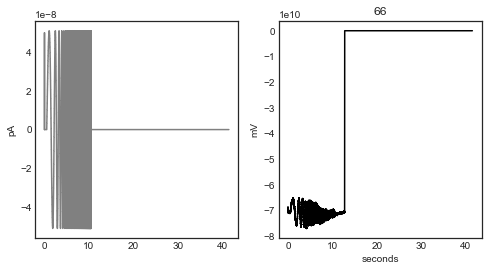

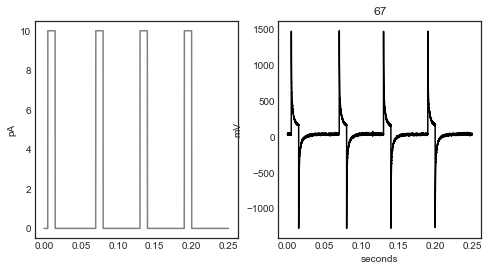

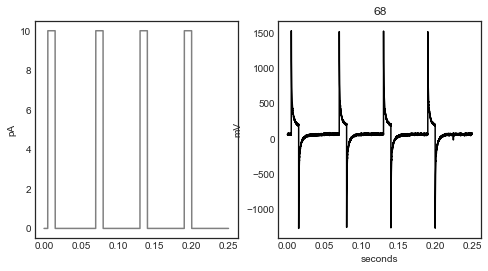

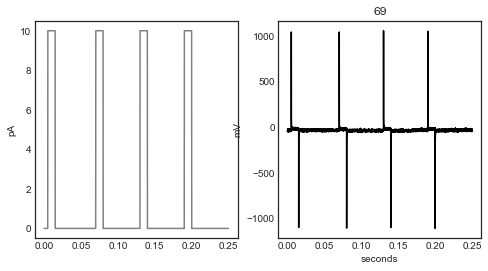

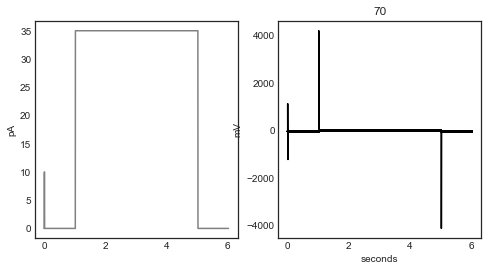

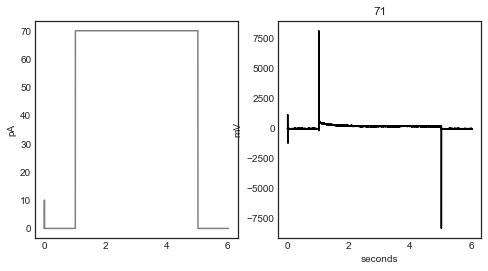

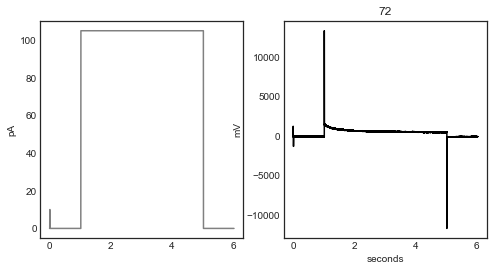

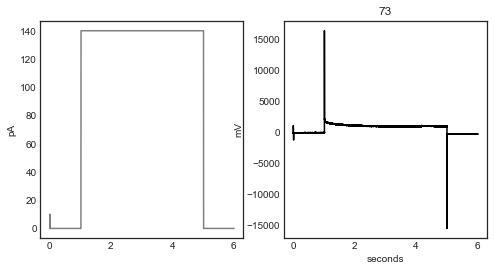

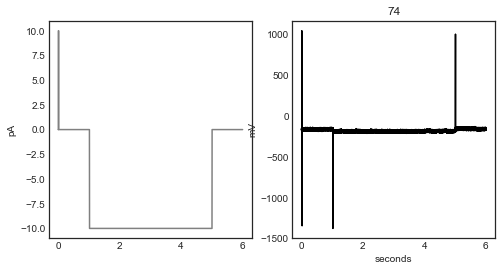

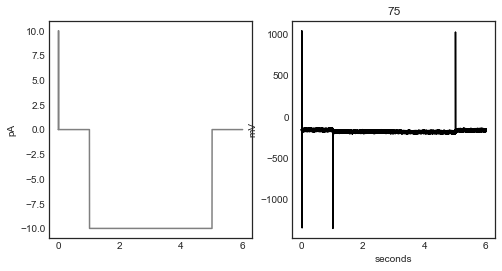

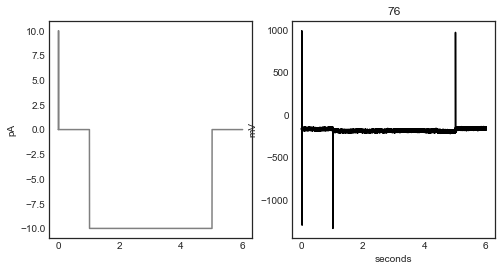

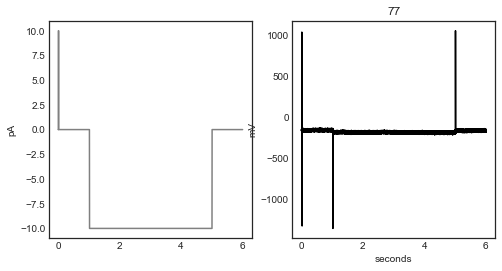

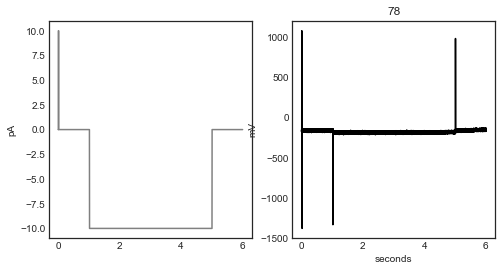

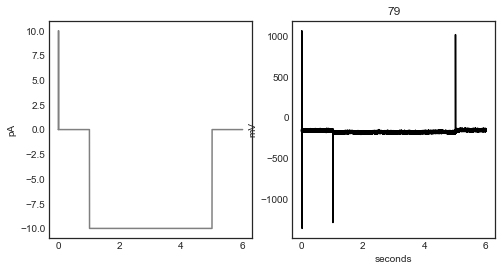

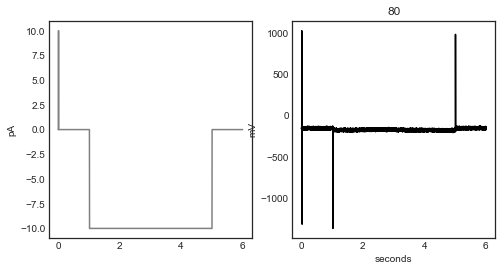

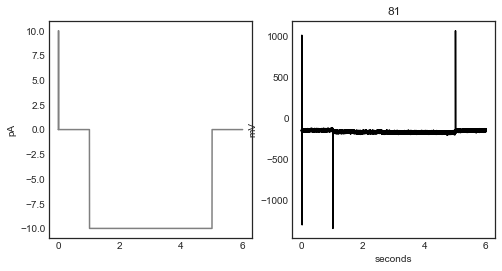

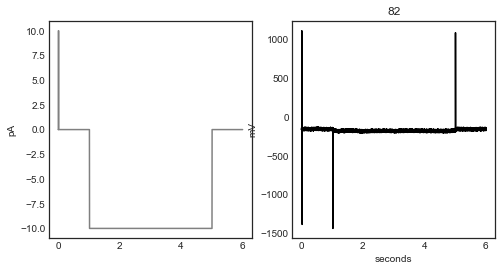

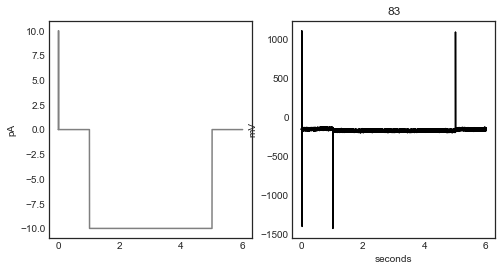

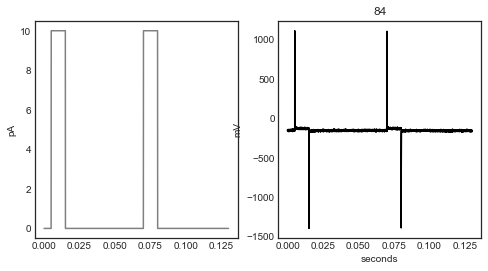

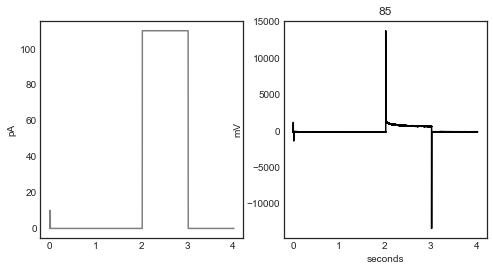

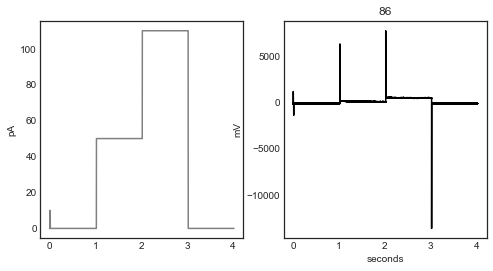

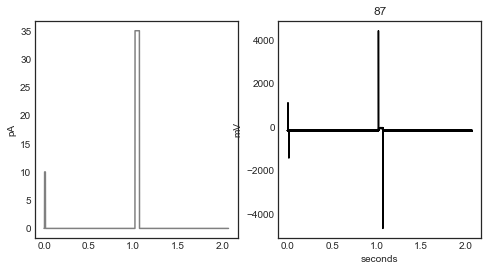

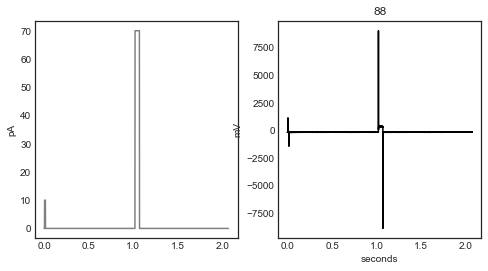

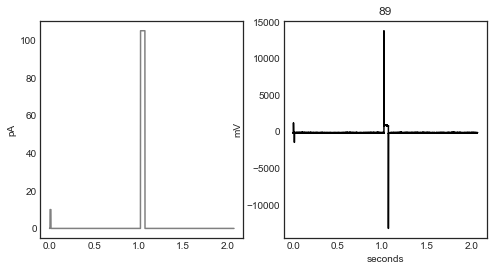

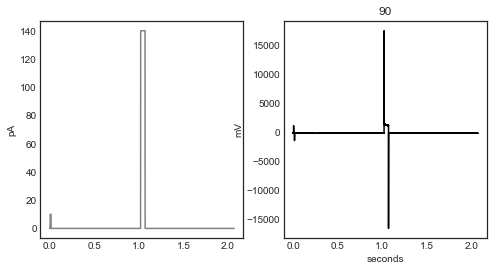

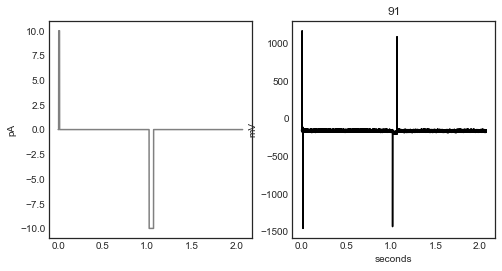

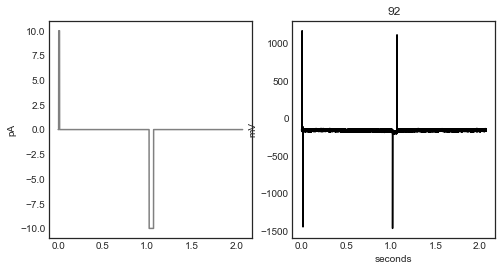

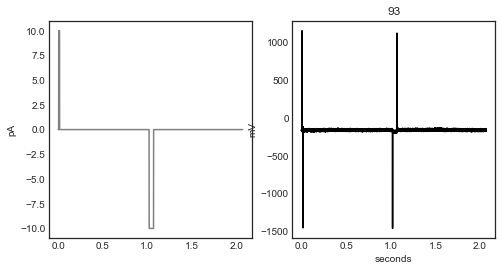

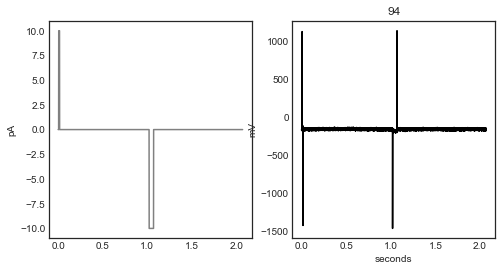

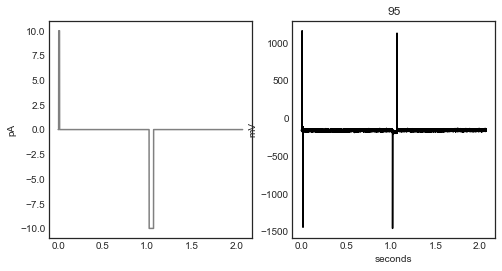

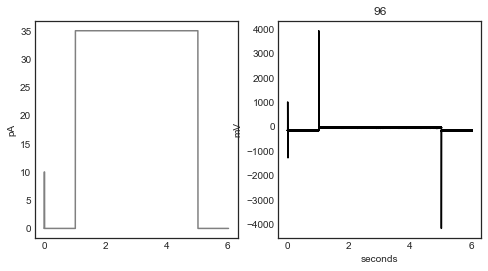

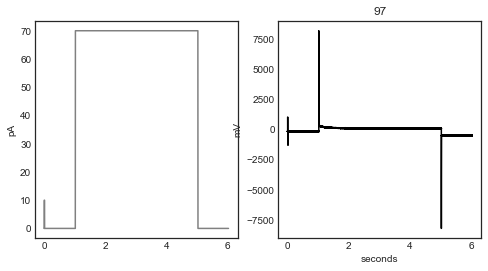

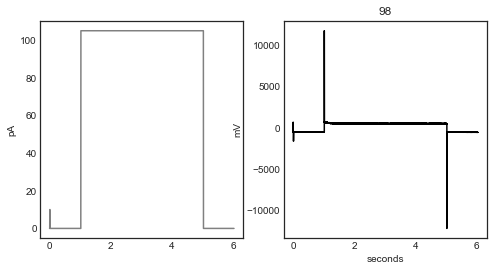

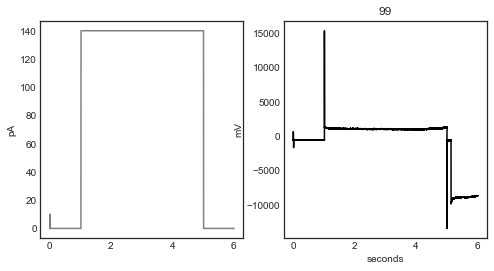

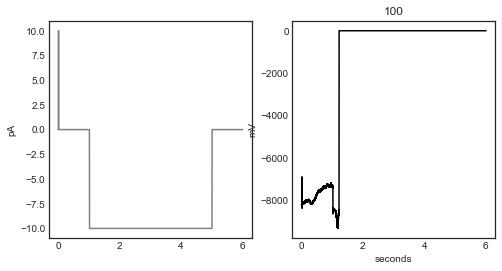

In [8]:
cell = raw_input('Cell: ').strip()

conn = pg8000.connect(user="limsreader", host="limsdb2", database="lims2", password="limsro", port=5432)
cur = conn.cursor()

cur.execute("SELECT cell.id AS cell_id, cell.name AS cell_name, err.id AS roi_id, \
err.storage_directory AS path \
FROM specimens cell \
JOIN specimens slice ON cell.parent_id = slice.id \
JOIN ephys_roi_results err ON err.id = cell.ephys_roi_result_id \
WHERE cell.name ilike %s",(cell,))
result = cur.fetchone()

if result != None:
    nwb_path = nwb_linux(result[3])
    data = NwbDataSet(nwb_path)
    
    for sweep in sorted(data.get_sweep_numbers()):
        sweep_data = data.get_sweep(sweep)
        sampling_rate = sweep_data["sampling_rate"] # in Hz
        index_range = sweep_data["index_range"]
        i = sweep_data["stimulus"][0:index_range[1]+1] # in A
        v = sweep_data["response"][0:index_range[1]+1] # in V
        t = np.arange(0, len(v)) * (1.0 / sampling_rate)

        i *= 1e3 # to pA
        v *= 1e12 # to mV
        fig, axes = plt.subplots(1, 2, sharex=True, figsize = (8,4))
        axes[0].plot(t, i, color='gray')
        axes[1].plot(t, v, color='black')
        axes[0].set_ylabel("pA")
        axes[1].set_ylabel("mV")
        axes[1].set_xlabel("seconds")
        axes[1].set_title(sweep)

if result == None:
    print 'Could not find cell'


In [6]:
len(v)

301000

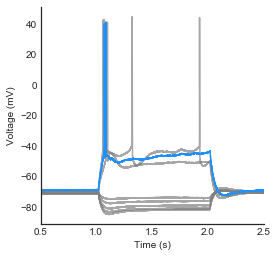

In [157]:
sweeps = [4,5,6,7,8,10,12]
hero_sweep = 11

plt.figure(figsize = (4,4))
for sweep in sweeps:
    sweep_data = data.get_sweep(sweep)
    response = sweep_data["response"]
    response *= 1e3 # to pA
    t = np.arange(0,len(response))*(1.0/50000)
    plt.plot(t,response, color = 'gray', alpha = .7)
sweep_data = data.get_sweep(hero_sweep)
response = sweep_data["response"]
response *= 1e3 # to pA
t = np.arange(0,len(response)) *(1.0/50000)
plt.plot(t,response, color = 'dodgerblue')
plt.xlim(0.502,2.502)
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (s)')
sns.despine()
plt.savefig('single_channel_images\\' + cell + '_thumbnail.png')

In [13]:
#collect all the correct sweep numbers
sweep_start = raw_input('Enter first sweep of the set: ')
try:
    sweep_start = int(sweep_start)
except ValueError:
    print 'Try again'
sweep_end = raw_input('Enter last sweep of the set: ')
try:
    sweep_end = int(sweep_end) +1
except ValueError:
    print 'Try again'
    
"""
experiment sweeps go in this order:
+ 35 mV
+ 70 mV
+ 105 mV
+ 140 mV
- 10 mV x 10
seal test
+ 110 mV
+ 50/110 mV
+ 35 mV
+ 70 mV
+ 105 mV
+ 140 mV
- 10 mV x 5
"""
remainder = (sweep_end - sweep_start)%26
cycles = (sweep_end - sweep_start + -remainder)/26

exp_1, exp_2, exp_3, exp_4, exp_5, exp_6, seals, exp_7, exp_8, exp_9, exp_10 = [cycles] * 11
leak = cycles * 10
s_leak = cycles * 5
if cycles == 0:
    leak = 10
    s_leak = 5
    
    
if remainder > 0:
    exp_1 += 1
if remainder > 1:
    exp_2 += 1
if remainder > 2:
    exp_3 += 1
if remainder > 3:
    exp_4 += 1
if remainder > 4 and remainder < 15:
    leak += remainder -4
if remainder > 14:
    seals += 1
if remainder > 15:
    exp_5 += 1
if remainder > 16:
    exp_6 += 1
if remainder > 17:
    exp_7 += 1
if remainder > 18:
    exp_8 += 1
if remainder > 19:
    exp_9 += 1
if remainder > 20:
    exp_10 += 1
if remainder > 21 and remainder < 26:
    s_leak += remainder 
#create arrays to hold all of the sweeps

"""
these are known values as of 11/10/17
exp_1, exp_2, exp_3, exp_4 and leak are 301000
exp_5 and exp_6 are 201000
seals are 6500
"""

exp_1 = np.zeros((exp_1,301000))
exp_2 = np.zeros((exp_2, 301000))
exp_3 = np.zeros((exp_3, 301000))
exp_4 = np.zeros((exp_4, 301000))
leak = np.zeros((leak, 301000))
seals = np.zeros((seals, 6500))
exp_5 = np.zeros((exp_5, 201000))
exp_6 = np.zeros((exp_6, 201000))
exp_7 = np.zeros((exp_7, 103500))
exp_8 = np.zeros((exp_8, 103500))
exp_9 = np.zeros((exp_9, 103500))
exp_10 = np.zeros((exp_10, 103500))
s_leak = np.zeros((s_leak, 103500))

stims = {
    1: exp_1,
    2: exp_2,
    3: exp_3,
    4: exp_4,
    5: leak,
    6: leak,
    7: leak,
    8: leak,
    9: leak,
    10: leak,
    11: leak,
    12: leak,
    13: leak,
    14: leak,
    15: seals,
    16: exp_5,
    17: exp_6,
    18: exp_7,
    19: exp_8,
    20: exp_9,
    21: exp_10,
    22: s_leak,
    23: s_leak,
    24: s_leak,
    25: s_leak,
    26: s_leak,
}

count = 1
cycles = 0
leak_count = 0
s_leak_count = 0
g_seal = []
cap_set = []
#add the sweeps into the proper arrays

for sweep in range(sweep_start, sweep_end):
        
        #get data from nwb 
        sweep_data = data.get_sweep(sweep)
        response = sweep_data["response"]
        response *= 1e12 # to pA 
        response = response-response[0]
        stim = sweep_data["stimulus"]
        stim *= 1e3 # to mV
        
        i_ss = abs(response[1230:1249].mean() - response[730:749].mean())
        g_seal.append(10000/i_ss)
        
        cap_peak = abs(response).max()
        cap_idx = abs(response).argmax()
        cap_set.append(cap_peak/abs(stim[cap_idx]))
        
        if count > 4 and count < 15:
            stims[count][leak_count] = response
            leak_count += 1
        elif count > 22 and count < 27:
            stims[count][s_leak_count] = response
            s_leak_count += 1
        else:
            stims[count][cycles] = response
        if count < 26:
            count += 1
        else:
            count = 1
            cycles += 1

Enter first sweep of the set: 70
Enter last sweep of the set: 98


In [143]:
sweep

104

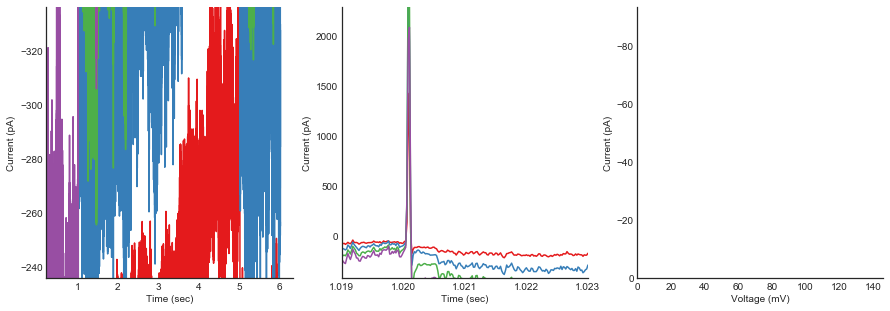

In [8]:
#plot the IV curve of exp 1-4
#subplots of traces next to IV
leak_mean = leak.mean(axis=0)
t = np.arange(0,len(leak_mean)) * (1.0/50000)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))

y = exp_1.mean(axis = 0)[:len(leak_mean)] - (leak_mean * -3.5)
ax1.plot(t, y, color = '#e41a1c')
ax2.plot(t, y, color = '#e41a1c')
#ax3.scatter(35, y[45000:100000].max(), color = '#e41a1c')
ax3.scatter(35, y[51025:100000].max(), color = '#e41a1c')
#get the values to automate
y_min_1 = y[50000:51250].min()*1.1

y = exp_2.mean(axis = 0)[:len(leak_mean)] - (leak_mean * -7)
ax1.plot(t, y, color = '#377eb8')
ax2.plot(t, y, color = '#377eb8')
#ax3.scatter(70, y[45000:100000].max(), color = '#377eb8')
ax3.scatter(70, y[51025:100000].max(), color = '#377eb8')
y_min_2 = y[50000:51250].min()*1.1

y = exp_3.mean(axis = 0)[:len(leak_mean)] - (leak_mean * -10.5)
ax1.plot(t, y, color = '#4daf4a')
ax2.plot(t, y, color = '#4daf4a')
#ax3.scatter(105, y[45000:100000].max(), color = '#4daf4a')
ax3.scatter(105, y[51025:100000].max(), color = '#4daf4a')

y = exp_4.mean(axis = 0)[:len(leak_mean)] - (leak_mean * -14)
ax1.plot(t, y, color = '#984ea3')
ax2.plot(t, y, color = '#984ea3')
#ax3.scatter(140, y[45000:100000].max(), color = '#984ea3')
ax3.scatter(140, y[51025:100000].max(), color = '#984ea3')

y_max_1 = y[51250:100000].max()*1.1
y_max_2 = y[50000:51250].max()*1.1


ax1.set_ylim(y_min_1, y_max_1)
ax1.set_xlim(.23,)
ax2.set_ylim(y_min_2,y_max_2)
ax2.set_xlim(1.019,1.023)
ax3.set_xlim(0,)
ax3.set_ylim(0,)
ax1.set_xlabel('Time (sec)')
ax2.set_xlabel('Time (sec)')
ax1.set_ylabel('Current (pA)')
ax2.set_ylabel('Current (pA)')
ax3.set_xlabel('Voltage (mV)')
ax3.set_ylabel('Current (pA)')
sns.despine()
#f.suptitle('Voltage Steps')
f.savefig('single_channel_images\\' + cell + '_steps.png')

In [118]:
250.0/50000

0.005

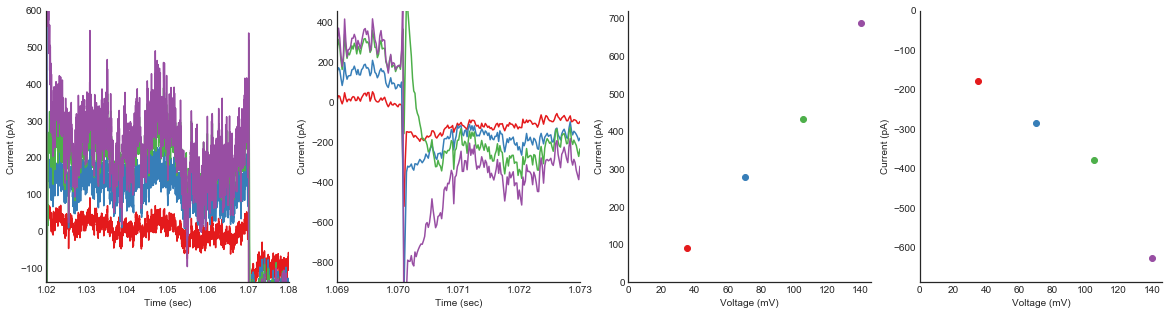

In [9]:
#plot the IV curve of exp 7-10
#subplots of traces next to IV
s_leak_mean = s_leak.mean(axis=0)
t = np.arange(0,len(s_leak_mean)) * (1.0/50000)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20,5))

y = exp_7.mean(axis = 0)[:len(s_leak_mean)] - (s_leak_mean * -3.5)
ax1.plot(t, y, color = '#e41a1c')
ax2.plot(t, y, color = '#e41a1c')
ax3.scatter(35, y[51025:53500].max(), color = '#e41a1c')
ax4.scatter(35, y[53525:].min(), color = '#e41a1c')
y_min_1 = y[50000:51250].min()*1.1

y = exp_8.mean(axis = 0)[:len(s_leak_mean)] - (s_leak_mean * -7)
ax1.plot(t, y, color = '#377eb8')
ax2.plot(t, y, color = '#377eb8')
ax3.scatter(70, y[51025:53500].max(), color = '#377eb8')
ax4.scatter(70, y[53525:].min(), color = '#377eb8')

y = exp_9.mean(axis = 0)[:len(s_leak_mean)] - (s_leak_mean * -10.5)
ax1.plot(t, y, color = '#4daf4a')
ax2.plot(t, y, color = '#4daf4a')
ax3.scatter(105, y[51025:53500].max(), color = '#4daf4a')
ax4.scatter(105, y[53525:].min(), color = '#4daf4a')

y = exp_10.mean(axis = 0)[:len(s_leak_mean)] - (s_leak_mean * -14)
ax1.plot(t, y, color = '#984ea3')
ax2.plot(t, y, color = '#984ea3')
ax3.scatter(140, y[51025:53500].max(), color = '#984ea3')
ax4.scatter(140, y[53525:].min(), color = '#984ea3')


y_max_1 = y[51250:100000].max()*1.1
y_min_2 = y[53510:53650].min() * 1.1
y_max_2 = y[53450:53500].max() * 1.1

ax1.set_ylim(y_min_1, y_max_1)
ax1.set_xlim(1.02,1.08)
ax2.set_ylim(y_min_2, y_max_2)
ax2.set_xlim(1.069,1.073)
ax3.set_xlim(0,)
ax3.set_ylim(0,)
ax4.set_xlim(0,)
ax4.set_ylim(y[53525:].min()*1.1,0)
ax1.set_xlabel('Time (sec)')
ax2.set_xlabel('Time (sec)')
ax1.set_ylabel('Current (pA)')
ax2.set_ylabel('Current (pA)')
ax3.set_xlabel('Voltage (mV)')
ax3.set_ylabel('Current (pA)')
ax4.set_xlabel('Voltage (mV)')
ax4.set_ylabel('Current (pA)')
sns.despine()
#f.suptitle('Voltage Steps')
f.savefig('single_channel_images\\' + cell + '_steps_short.png')

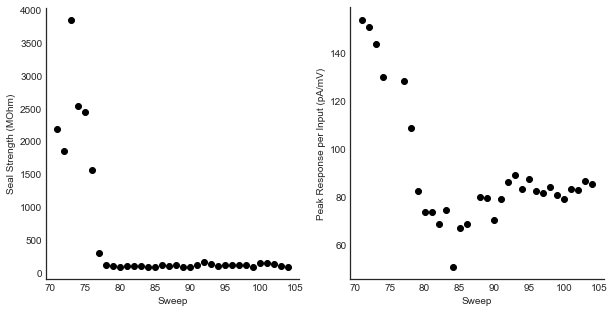

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

ax1.scatter(np.arange(sweep_start,sweep_end),g_seal, color = 'black')
ax1.set_xlabel('Sweep')
ax1.set_ylabel('Seal Strength (MOhm)')

ax2.scatter(np.arange(sweep_start,sweep_end),cap_set, color = 'black')
ax2.set_xlabel('Sweep')
ax2.set_ylabel('Peak Response per Input (pA/mV)')

sns.despine()
plt.savefig('single_channel_images\\' + cell + '_seal.png')

In [75]:
50000*2.0205

101025.00000000001

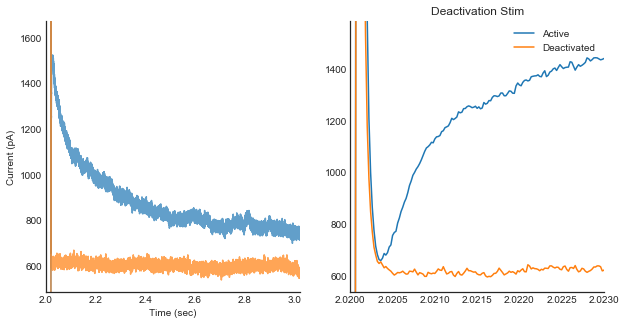

In [14]:
#plot difference
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

t = np.arange(0,len(exp_5[0])) * (1.0/50000)

ax1.plot(t,exp_5.mean(axis = 0), label = 'Active', alpha = .7)
ax1.plot(t,exp_6.mean(axis = 0), label = 'Deactivated', alpha = .7)

"""ax1.plot(t,exp_6.mean(axis = 0) - exp_5.mean(axis = 0)+(exp_5.mean(axis = 0)[101250]+exp_6.mean(axis = 0)[101250])/2, 
        label = 'Subtracted', alpha = .7)"""

ax2.plot(t,exp_5.mean(axis = 0), label = 'Active', alpha = 1)
ax2.plot(t,exp_6.mean(axis = 0), label = 'Deactivated', alpha = 1)

"""ax2.plot(t,exp_6.mean(axis = 0) - exp_5.mean(axis = 0)+(exp_5.mean(axis = 0)[101250]+exp_6.mean(axis = 0)[101250])/2, 
         label = 'Subtracted', alpha = 1)"""

y_min_1 = exp_6.mean(axis = 0)[101250:150000].min()*.9
y_max_1 = exp_5.mean(axis = 0)[101250:150000].max()*1.1
y_min_2 = exp_6.mean(axis = 0)[101005:101150].min()*.9
y_max_2 = exp_5.mean(axis = 0)[101025:101150].max()*1.1


ax1.set_ylim(y_min_1, y_max_1)
ax2.set_ylim(y_min_2, y_max_2)
ax1.set_xlim(2.00,3.02)
ax2.set_xlim(2.02,2.023)
plt.legend()
sns.despine()
ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Current (pA)')
plt.title('Deactivation Stim')
plt.savefig('single_channel_images\\' + cell + '_deactivation.png')

In [155]:
1.025*50000

51249.99999999999

(-100, 100)

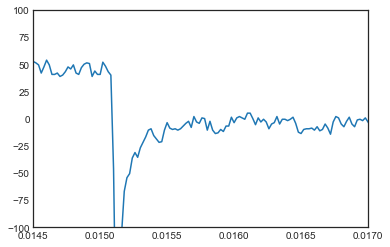

In [58]:
plt.plot(np.arange(0,len(response))*1.0/50000, response)
plt.xlim(.0145,.017)
plt.ylim(-100,100)

In [67]:
len(leak.mean(axis = 0))

301000

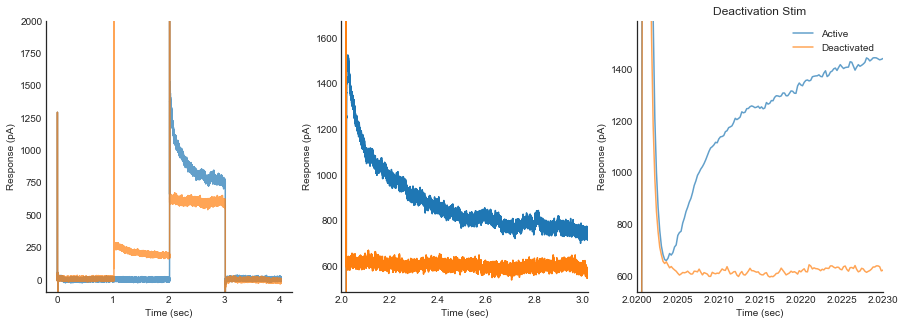

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))

t = np.arange(0,len(exp_5[0])) * (1.0/50000)

ax1.plot(t,exp_5.mean(axis = 0), label = 'Active', alpha = .7)
ax1.plot(t,exp_6.mean(axis = 0), label = 'Deactivated', alpha = .7)

"""ax1.plot(t,exp_6.mean(axis = 0) - exp_5.mean(axis = 0)+(exp_5.mean(axis = 0)[101250]+exp_6.mean(axis = 0)[101250])/2, 
        label = 'Subtracted', alpha = .7)"""

ax2.plot(t,exp_5.mean(axis = 0), label = 'Active', alpha = 1)
ax2.plot(t,exp_6.mean(axis = 0), label = 'Deactivated', alpha = 1)

"""ax2.plot(t,exp_6.mean(axis = 0) - exp_5.mean(axis = 0)+(exp_5.mean(axis = 0)[101250]+exp_6.mean(axis = 0)[101250])/2, 
         label = 'Subtracted', alpha = 1)"""

ax3.plot(t,exp_5.mean(axis = 0), label = 'Active', alpha = .7)
ax3.plot(t,exp_6.mean(axis = 0), label = 'Deactivated', alpha = .7)


y_min_1 = exp_6.mean(axis = 0)[101250:150000].min()*.9
y_max_1 = exp_5.mean(axis = 0)[101250:150000].max()*1.1
y_min_2 = exp_6.mean(axis = 0)[101005:101150].min()*.9
y_max_2 = exp_5.mean(axis = 0)[101025:101150].max()*1.1


ax1.set_ylim(-100,2000)
ax2.set_ylim(y_min_1, y_max_1)
ax3.set_ylim(y_min_2, y_max_2)
ax2.set_xlim(2.00,3.02)
ax3.set_xlim(2.02,2.023)
plt.legend()
sns.despine()
ax1.set_xlabel('Time (sec)')
ax2.set_xlabel('Time (sec)')
ax3.set_xlabel('Time (sec)')

ax1.set_ylabel('Response (pA)')
ax2.set_ylabel('Response (pA)')
ax3.set_ylabel('Response (pA)')
plt.title('Deactivation Stim')
plt.savefig('single_channel_images\\' + cell + '_deactivation_exp.png')